# Neural Networks Learning

This Matlab code has been completed as part of [Machine Learning](https://www.coursera.org/learn/machine-learning)
course in Coursera given by Prof. Andrew Ng

------------
This note demonstrates the implementation of the backpropagation algorithm for neural networks and apply it to the task of hand-written digit recognition.

This notebook includes:

- <a href='#part1'>Part 1: Visualizing the data</a>
- <a href='#part2'>Part 2: Model representation</a>
- <a href='#part3'>Part 3: Feedforward and cost function</a> 
- <a href='#part4'>Part 4: Backpropagation</a> 
- <a href='#part5'>Part 5: Learning parameters using fmincg</a> 
- <a href='#part6'>Part 6: Visualizing the hidden layer</a> 
- <a href='#part7'>Part 7: Neural Networks Prediction</a> 

This code requires the following functions
* <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_06_NeuralNetworks_nnCostFunction.m'>
funcs_06_NeuralNetworks_nnCostFunction.m</a> 
* <a href='https://github.com/linhvannguyen/MachineLearning_AndrewNG/blob/master/matlab/funcs/funcs_06_NeuralNetworks_displayData.m'>funcs_06_NeuralNetworks_displayData.m</a>

In [1]:
clear all; close all; clc; warning off;
addpath('../data/') % add path to directory containing data files
addpath('./funcs/') % add path to directory containing subfunction files

## Part 1: Visualizing the data <a id='part1'></a>

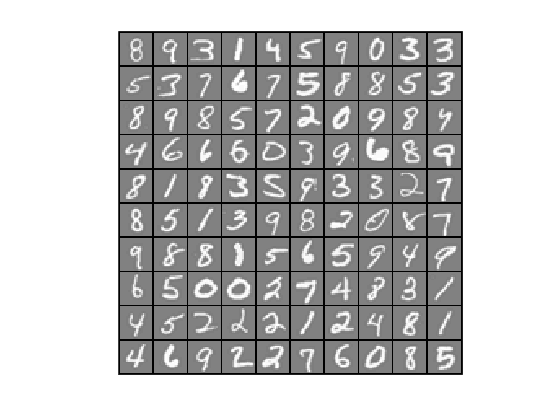

In [2]:
load('data_06_NeuralNetworks.mat');

% Randomly select 100 data points to display
sel = randperm(size(X, 1));
sel = sel(1:100);
funcs_06_NeuralNetworks_displayData(X(sel, :));

## Part 2: Model representation <a id='part2'></a>
Our neural network is shown in Figure 2. It has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values

#### Setup the parameters for the training

In [3]:
input_layer_size  = 400;  % 20x20 Input Images of Digits
hidden_layer_size = 25;   % 25 hidden units
num_labels = 10;          % 10 labels, from 1 to 10   
                          % (note that we have mapped "0" to label 10)
m = size(X, 1);           % 20x20 Input Images of Digits
n = size(X, 1);           % 20x20 Input Images of Digits

#### Randomly Initializing weights
When training neural networks, it is important to randomly initialize the parameters for symmetry breaking. One effective strategy for random initialization is to randomly select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init} ]$. One effective strategy for choosing init is to base it on the number of units in the network. A good choice of init is $\epsilon_{init} = \frac{\sqrt(6)}{\sqrt{L_{in}+L_{out}}}$ where $L_{in} = s_l$ and $L_{out} = s_{l+1}$ are the number of units in the layers adjacent to $\Theta^{(l)}$ . This range of values ensures that the parameters are kept small and makes the learning more efficient.

In our case,  $\epsilon_{init} = 0.12$. 

In [4]:
epsilon_init = 0.12;
initial_Theta1 = rand(hidden_layer_size, 1 + input_layer_size) * 2 * epsilon_init - epsilon_init;
initial_Theta2 = rand(num_labels, 1 + hidden_layer_size) * 2 * epsilon_init - epsilon_init;

% Unroll parameters
initial_nn_params = [initial_Theta1(:) ; initial_Theta2(:)];

**Sigmoid gradient**
The gradient for the sigmoid function $$g(z)= \frac{1}{1+exp(z)}$$  can be computed as:

$$ g'(z) = \frac{d}{d z}g(z) = g(z)\left( 1-g(z)\right)$$

In [5]:
sigmoid=@(z) 1.0 ./ (1.0 + exp(-z)); % sigmoid function
sigmoidGradient = @(z) sigmoid(z).*(1-sigmoid(z)); % gradient of sigmoid function

## Part 3: Feedforward and cost function <a id='part3'></a>

The cost function for the neural network (without regularization) is:

$$J^{noreg}(\theta)=\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} \left[ -y_k^{(i)} log \left(\left(h_{\theta} \left(x^{(i)} \right)\right)_k\right) - \left(1-y_k^{(i)}\right) log \left(1-\left(h_{\theta} \left(x^{(i)} \right)\right)_k\right)\right]$$

where $h_{\theta} \left(x^{(i)}\right)$ is computed as shown in the Figure and K = 10 is the total number of possible labels. Note that $h_{\theta} \left(x^{(i)}\right)_k = a_k^{(3)}$ is the activation (output value) of the k-th output unit. Also, recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1, so that $y= [1 \:\: 0 \:\: ... \:\: 0]^T, [0 \:\: 1 \:\: ... \:\: 0]^T, ...,$ or $[0 \:\: 0 \:\: ... \:\: 1]^T \in R^K$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$ and the other elements equal to 0.

The cost function for neural networks with regularization is given by

$$ J^{reg}(\theta)=J^{noreg} + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right]$$

You can assume that the neural network will only have 3 layers – an input layer, a hidden layer and an output layer. However, your code should work for any number of input units, hidden units and outputs units.

Note that you should **not** be regularizing the terms that correspond to the bias. For the matrices ** *Theta1* ** and ** *Theta2* **, this corresponds to the first column of each matrix. You should now add regularization to your cost function. Notice that you can first compute the unregularized cost function $J$ using your existing ** *nnCostFunction.m* ** and then later add the cost for the regularization terms.

In [6]:
%     %%    % Part 1: Feedforward the neural network and return the cost in the
%     %         variable J. 
%     % Estimate actuators and outputs of each layers
%     Theta_all={Theta1,Theta2,[]};
%     A_all{1}=X; Z_all{1}=[];
%     for layer_id=2:3
%         Z_all{layer_id}=[ones(m, 1) A_all{layer_id-1}]*Theta_all{layer_id-1}';
%         A_all{layer_id}=sigmoid(Z_all{layer_id});
%     end
%     
%     % full labels of all classes (contains only 0 and 1)
%     Y=zeros(size(A_all{end}));
%     for label_id=1:num_labels
%         y_oneclass=zeros(size(y));
%         if num_labels==0
%             y_oneclass(y==10)=1;
%         else
%             y_oneclass(y==label_id)=1;
%         end
%         Y(:,label_id)=y_oneclass;
%     end
%     
%     % Estimate cost function without regularization term
%     J = 1/m*sum(sum(-Y.*log(A_all{end})-(1-Y).*log(1-A_all{end})));
% 
%     % Estimate regularization terms
%     reg_term=0;
%     for layer_id=2:3
%         reg_term = reg_term + lambda/(2*m)*sum(sum(Theta_all{layer_id-1}(:,2:end).^2));
%     end  
%     
%     % Estimate cost function with regularization term
%     J = J+reg_term;

## Part 4: Backpropagation <a id='part4'></a>

The intuition behind the backpropagation algorithm is as follows. Given a training example $(x^{(t)}, y^{(t)})$, we will first run a "forward pass" to compute all the activations throughout the network, including the output value of the hypothesis $h_{\Theta}(x)$. Then, for each node $j$ in layer $l$, we would like to compute an "error term" $\delta_j^{(l)}$ that measures how much that node was "responsible" for any errors in our output. 

For an output node, we can directly measure the difference between the network's activation and the true target value, and use that to define $\delta_j^{(3)}$ (since layer 3 is the output layer). For the hidden units, you will compute $\delta_j^{(l)}$ based on a weighted average of the error terms of the nodes in layer (l + 1).

In detail, here is the backpropagation algorithm. You should implement steps 1 to 4 in a loop that processes one example at a time. Concretely, you should implement a for-loop for $t = 1:m$ and place steps 1-4 below inside the for-loop, with the $t^{th}$ iteration performing the calculation on the $t^{th}$ training example $(x^{(t)}, y^{(t)})$. Step 5 will divide the accumulated gradients by $m$ to obtain the gradients for the neural network cost function.
1. Set the input layer's values $(a^{(1)})$ to the $t^{th}$ training example $x^{(t)}$ . Perform a feedforward pass and compute the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3. Note that you need to add a "+1" term to ensure that the vectors of activations for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit.
2. For each output unit k in layer 3 (the output layer), set $\delta_k^{(3)}=\left( a_k^{(3)} - y_k\right)$ where $y_k \in \{0,1\}$ indicates whether the current training example belongs to class k $(y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.
3. For the hidden layer l = 2, set $\delta^{(2)}= \left( \Theta^{(2)} \right)^T \delta^{(3)}.*g'\left( z^{(2)} \right)$
4. Accumulate the gradient from this example using the following formula. $$\Delta^{(l)}=\Delta^{(l)}+\delta^{(l+1)}\left( a^{(l)} \right)^T$$ Note that you should skip or remove $\delta_0^{(2)}$
5. Obtain the (regularized) gradient for the neural network cost function: $$ \frac{\partial}{\partial \Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)}=\frac{1}{m}\Delta_{ij}^{(l)} \qquad for \quad j=0$$  $$ \frac{\partial}{\partial \Theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)}=\frac{1}{m}\Delta_{ij}^{(l)} + \frac{1}{m}\Theta_{ij}^{(l)} \qquad for \quad j > 0$$

Note that you should not be regularizing the first column $\Theta^{(l)}$ which is used for the bias term.

In [7]:
%     %%     % Part 2: Implement the backpropagation algorithm to compute the gradients
%     %         Theta1_grad and Theta2_grad. You should return the partial derivatives of
%     %         the cost function with respect to Theta1 and Theta2 in Theta1_grad and
%     %         Theta2_grad, respectively.
%     
%     % step 2 and 3
%     delta_all{1}=[]; % there is no grad for first layer
%     for layer_id=3:-1:2
%         if layer_id==3
%             delta_all{layer_id}=A_all{layer_id}-Y;
%         else
%             delta_all{layer_id}=delta_all{layer_id+1}*Theta_all{layer_id}(:,2:end).*sigmoidGradient(Z_all{layer_id});
%         end
%     end
%     
%     % step 4 and 5
%     Theta_grad_all{3}=[];
%     for layer_id=1:2
%         A=[ones(size(A_all{layer_id},1),1) A_all{layer_id}]; % add ones to actuators
%         Theta_grad_all{layer_id}=1/m*delta_all{layer_id+1}'*A;
%     end
% 
%     %%     % Part 3: Implement regularization with the cost function and gradients.
%     %
%     %         Hint: You can implement this around the code for
%     %               backpropagation. That is, you can compute the gradients for
%     %               the regularization separately and then add them to Theta1_grad
%     %               and Theta2_grad from Part 2.
%     %
%     for layer_id=1:2
%         regterm_grad = [zeros(size(Theta_all{layer_id},1),1) lambda/m*Theta_all{layer_id}(:,2:end)];
%         Theta_grad_all{layer_id}=Theta_grad_all{layer_id}+regterm_grad;
%     end
% 
%     grad=[Theta_grad_all{1}(:); Theta_grad_all{2}(:)];

## Part 5: Learning parameters using fmincg <a id='part5'></a>
After you have successfully implemented the neural network cost function and gradient computation, the next step of the ex4.m script will use ** *fmincg* **to learn a good set parameters. After the training completes, the ex4.m script will proceed to report the training accuracy of your classifier by computing the percentage of examples
it got correct. If your implementation is correct, you should see a reported training accuracy of about 95.3% (this may vary by about 1% due to the random initialization). It is possible to get higher training accuracies by training the neural network for more iterations. We encourage you to try training the neural network for more iterations (e.g., set MaxIter to 400) and also vary the regularization parameter λ. With the right learning settings, it is possible to get the neural network to perfectly fit the training set.

In [8]:
%  larger MaxIter might help the training
options = optimset('MaxIter', 50);

%  Regularization parameter
lambda = 1;

% Create "short hand" for the cost function to be minimized
costFunction = @(p)funcs_06_NeuralNetworks_nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda);

% Now, costFunction is a function that takes in only one argument (the neural network parameters)
[nn_params, cost] = funcs_fmincg(costFunction, initial_nn_params, options);
size(nn_params)
% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), hidden_layer_size, (input_layer_size + 1));
Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), num_labels, (hidden_layer_size + 1));


Last iteration (  50 th) | Cost: 5.325793e-01
ans =
       10285           1

## Part 6: Visualizing the hidden layer <a id='part6'></a>
One way to understand what your neural network is learning is to visualize what the representations captured by the hidden units. Informally, given a particular hidden unit, one way to visualize what it computes is to find an input $x$ that will cause it to activate (that is, to have an activation value $a_i^{(l)}$ close to 1). For the neural network you trained, notice that the $i^{th}$ row of $\Theta^{(1)}$ is a 401-dimensional vector that represents the parameter for the $i^{th}$ hidden unit. If we discard the bias term, we get a 400 dimensional vector that represents the weights from each input pixel to the hidden unit. 

Thus, one way to visualize the "representation" captured by the hidden unit is to reshape this 400 dimensional vector into a 20 × 20 image and display it. In the trained network, the hidden units corresponds roughly to detectors that look for strokes and other patterns in the input.

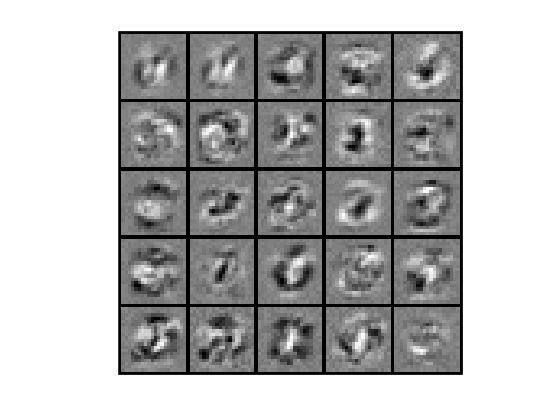

In [9]:
funcs_06_NeuralNetworks_displayData(Theta1(:, 2:end));

## Part 7: Neural Networks Prediction <a id='part7'></a>

In [10]:
h1 = sigmoid([ones(m, 1) X] * Theta1');
h2 = sigmoid([ones(m, 1) h1] * Theta2');
[~, pred] = max(h2, [], 2);
fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);

Training Set Accuracy: 95.060000

#### Sample prediction

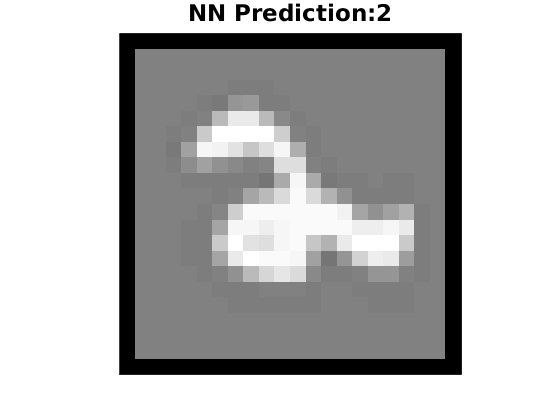

In [11]:
rp = randperm(m);

xi= X(rp(1), :);
A1=[1 xi];
Z2=A1*Theta1';
A2=sigmoid(Z2);

Z3=[1 A2]*Theta2';
A3=sigmoid(Z3);

[~,pred]=max(A3,[],2);

funcs_06_NeuralNetworks_displayData(xi);
title(['NN Prediction:',num2str(mod(pred, 10))]);

## Neural Networks and Regulariation

Neural networks are very powerful models that can form highly complex decision boundaries. Without regularization, it is possible for a neural network to "overfit" a training set so that it obtains close to 100% accuracy on the training set but does not as well on new examples that it has not seen before. To test this, we set the regularization $\lambda$ to a smaller value and the ** *MaxIter* ** parameter to a higher number of iterations to see the differences.

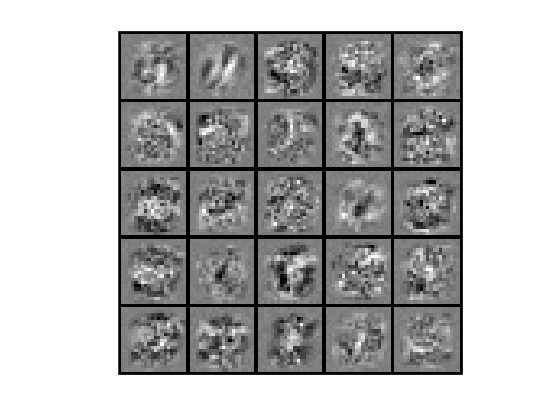

Last iteration ( 200 th) | Cost: 9.966739e-02
ans =
       10285           1

Training Set Accuracy: 99.800000

In [12]:
%  larger MaxIter might help the training
options = optimset('MaxIter', 200);

%  Regularization parameter
lambda = 0.1;

% Create "short hand" for the cost function to be minimized
costFunction = @(p)funcs_06_NeuralNetworks_nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lambda);

% Now, costFunction is a function that takes in only one argument (the neural network parameters)
[nn_params, cost] = funcs_fmincg(costFunction, initial_nn_params, options);
size(nn_params)
% Obtain Theta1 and Theta2 back from nn_params
Theta1 = reshape(nn_params(1:hidden_layer_size * (input_layer_size + 1)), hidden_layer_size, (input_layer_size + 1));
Theta2 = reshape(nn_params((1 + (hidden_layer_size * (input_layer_size + 1))):end), num_labels, (hidden_layer_size + 1));

h1 = sigmoid([ones(m, 1) X] * Theta1');
h2 = sigmoid([ones(m, 1) h1] * Theta2');
[~, pred] = max(h2, [], 2);
fprintf('\nTraining Set Accuracy: %f\n', mean(double(pred == y)) * 100);

funcs_06_NeuralNetworks_displayData(Theta1(:, 2:end));